In [1]:
import pyedflib
from pyedflib import EdfWriter, EdfReader

from scipy.io.wavfile import write
from scipy import signal as sci_sig
from scipy.spatial.distance import pdist
from scipy.signal import stft, hilbert, butter, freqz, filtfilt, find_peaks
from prettytable import PrettyTable
import os
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import argparse
import torch
import glob
import pickle
import random
import mne
import torch 
from mne.io.edf.edf import _read_annotations_edf, _read_edf_header
from itertools import groupby
#from foo_gt import resample_to_250,label_sampling_tuh #, get_foo_gt
from pathlib import Path
import re
from scipy.signal import resample,stft, hilbert, butter, freqz, filtfilt, find_peaks,lfilter,periodogram
from sklearn import preprocessing
from tqdm import tqdm

In [2]:
here = Path(f'{os.getcwd()}')
print(here)

d:\Graduate_School_Application\MS_Application_Projects\Neuro\TempleDataset\TUH_EEG_53gigs\Temple_Attempts


In [19]:
data_path= r'D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf'
#data_path= f'D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/pappu2'
train_path= data_path+r'/train'
val_path= data_path+r'/dev'
save_pckl_path = data_path + r'/segments/processed_pickle'
segments_path = data_path + r'/segments/balanced_binary'
#print(raw_path)

In [4]:
def build_data_file(eegdata_path):
    
    seizure_info = collections.namedtuple('seizure_info', ['patient_id','start_time', 'end_time','edf_file_path'])
    data_dict=collections.defaultdict(list)
    
    for dirpath, _, filenames in os.walk(eegdata_path):
        for filename in filenames:
            if filename.endswith('edf'):
                dir_split_inner = dirpath.split('\\')
                official_patient_number= dir_split_inner[3]
                processed_dir = '/'.join(dir_split_inner)
                Eeg_path=processed_dir+'/'+filename

                label_path = f'{Eeg_path[:-3]}tse'
                
                with open(label_path, 'rb') as f:
                    for line in f:
                        line = line.decode('utf-8').strip()
                        if line.startswith('version'):
                            next(f)  # Skip the line that starts with 'version'
                            continue  # Skip to the next iteration of the loop
                        
                        if line.strip():
                            # Split the line and process the parts
                            fields = line.split()
                            start_time_from_tse=float(fields[0])
                            end_time_from_tse=float(fields[1])
                            event_type=fields[2]
                            event_probability=float(fields[3])
    
                            v=seizure_info(patient_id=official_patient_number,start_time=start_time_from_tse, end_time=end_time_from_tse,edf_file_path=Eeg_path)
                            data_dict[event_type].append(v)
                            
    return data_dict


In [5]:
sz_datadict = build_data_file(train_path)

In [6]:
sz_datadict

defaultdict(list,
            {'bckg': [seizure_info(patient_id='00000077', start_time=0.0, end_time=1205.0, edf_file_path='D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.edf'),
              seizure_info(patient_id='00000254', start_time=0.0, end_time=1442.0, edf_file_path='D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.edf'),
              seizure_info(patient_id='00000254', start_time=0.0, end_time=1197.0, edf_file_path='D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/00000254_s006_t001.edf'),
              seizure_info(patient_id='00000254', start_time=0.0, end_time=1244.0, edf_file_path='D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gi

In [7]:
sz_datadict.keys()

dict_keys(['bckg', 'gnsz', 'tcsz', 'cpsz', 'fnsz', 'tnsz', 'spsz', 'absz', 'mysz'])

In [8]:
sz_datadict['bckg']

[seizure_info(patient_id='00000077', start_time=0.0, end_time=1205.0, edf_file_path='D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.edf'),
 seizure_info(patient_id='00000254', start_time=0.0, end_time=1442.0, edf_file_path='D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.edf'),
 seizure_info(patient_id='00000254', start_time=0.0, end_time=1197.0, edf_file_path='D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/00000254_s006_t001.edf'),
 seizure_info(patient_id='00000254', start_time=0.0, end_time=1244.0, edf_file_path='D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/00000254_s007_t000.edf'),


In [9]:
def dataset_info_table(data_dict):
    seizure_table = PrettyTable(["Seizure Type", "Number of Seizures", "Number of Patients","Total Duration (s)"])
    for k,v in data_dict.items():
            duration_event = [item.end_time - item.start_time for item in data_dict[k]]
            seizure_table.add_row([k, len(data_dict[k]), len(set([item.patient_id for item in data_dict[k]])), round(sum(duration_event),2)])
                    
    seizure_table.sortby = 'Total Duration (s)'
    seizure_table.reversesort = True
    return seizure_table

In [10]:
summary_table = dataset_info_table(sz_datadict)
print(summary_table)

+--------------+--------------------+--------------------+--------------------+
| Seizure Type | Number of Seizures | Number of Patients | Total Duration (s) |
+--------------+--------------------+--------------------+--------------------+
|     bckg     |        6976        |        592         |     2540689.26     |
|     fnsz     |        1536        |        126         |      88879.12      |
|     gnsz     |        409         |         68         |      46841.54      |
|     cpsz     |        283         |         34         |      27922.2       |
|     tcsz     |         30         |         9          |      1966.62       |
|     spsz     |         49         |         2          |      1941.52       |
|     mysz     |         2          |         1          |      1292.89       |
|     absz     |         50         |         7          |       494.86       |
|     tnsz     |         18         |         2          |       455.0        |
+--------------+--------------------+---

In [11]:
def dataset_plot(data_dict):
    
    
    number_of_classes = {k: len(v) for k, v in data_dict.items()}

    # Sorting the dictionary items by value in descending order
    sorted_all_events = sorted(number_of_classes.items(), key=lambda x: x[1], reverse=True)
    event_types, event_counts = zip(*sorted_all_events)

    # Wider figure for the subplots
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))  # 3 rows, 1 column

    # subplot for all seizure types
    axs[0].bar(event_types, event_counts)
    axs[0].set_xlabel('Event Type')
    axs[0].set_ylabel('Number of Events')
    axs[0].set_title('Event Labels')
    axs[0].set_xticklabels(event_types, rotation=70)  # Rotate x-axis labels

    # duration for each event type in non_background_events
    sz_dict={}
    for k,v in data_dict.items():
        if k != 'bckg':
            duration_sz=[x.end_time-x.start_time for x in data_dict[k]]
            axs[2].hist(duration_sz, bins=50)
            
            sz_dict[k]=len(v)
            sorted_sz_dict = dict(sorted(sz_dict.items(), key=lambda x: x[1], reverse=True))

    seizure_types, seizure_counts = zip(*sorted_sz_dict.items())
    # Create subplot excluding 'bckg'
    axs[1].bar(seizure_types, seizure_counts)
    axs[1].set_xlabel('Seizure Type')
    axs[1].set_ylabel('Number of Seizures')
    axs[1].set_title('Seizure Labels')
    axs[1].set_xticklabels(seizure_types, rotation=70)  # Rotate x-axis labels

    # Create subplot for duration frequency plot
    #axs[2].hist(duration_sz, bins=50)
    axs[2].set_xlabel('Seizure Duration (s)')
    axs[2].set_ylabel('Number of Occurences ')
    axs[2].set_title('Duration Frequency Plot')

    # Adjust layout for better visibility
    plt.subplots_adjust(hspace=0.5)  # Adjust the space between subplots
    plt.show()

C:\Users\durka\AppData\Local\Temp\ipykernel_26948\1122023591.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(event_types, rotation=70)  # Rotate x-axis labels
C:\Users\durka\AppData\Local\Temp\ipykernel_26948\1122023591.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(seizure_types, rotation=70)  # Rotate x-axis labels


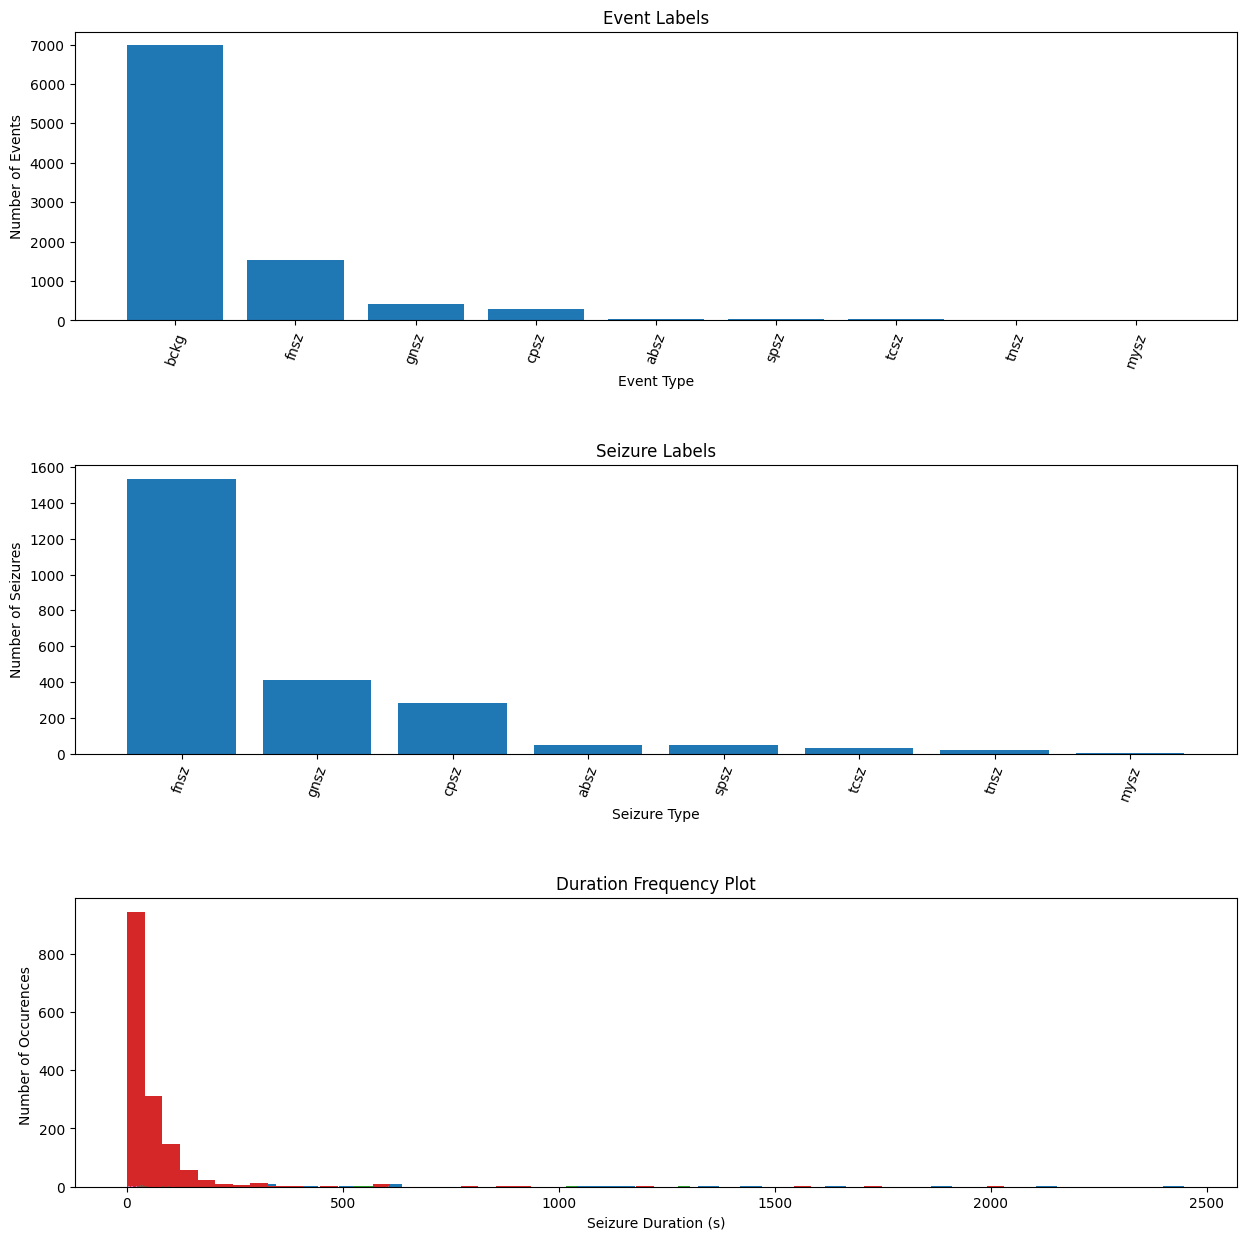

In [12]:
dataset_plot(sz_datadict)

### Bipolar referencing

In [13]:
def electrode_2_label(electrode, labels):
    for label in labels:
        match = re.search(r'EEG (\w+)-REF|LE', label)
        if match and match.group(1) == electrode:
            return label

In [14]:
def extract_seizure_from_electrode(f,channel,start,stop):
    
    signal = np.array(f.readSignal(channel))

    start, stop = float(start), float(stop)
    original_sample_frequency = f.getSampleFrequency(channel)
    original_start_index = int(np.floor(start * float(original_sample_frequency)))
    original_stop_index = int(np.floor(stop * float(original_sample_frequency)))

    seizure_signal = signal[original_start_index:original_stop_index]
    #new_sample_frequency = int(200)
    new_sample_frequency = int(250)
    new_num_time_points = int(np.floor((stop - start) * new_sample_frequency))
    seizure_signal_resampled = resample(seizure_signal, new_num_time_points)
    return seizure_signal_resampled

In [15]:
def apply_bipolar_montage(edf_path,edf_start,edf_stop):
    f = pyedflib.EdfReader(edf_path)
    all_signal_labels = f.getSignalLabels()
    if not all_signal_labels:
        raise ValueError("No signal labels found in the EDF file.")
    
    electrode_labels = [label for label in all_signal_labels if re.search(r'EEG (\w+)-REF|LE', label)]
    
    labels_montage = ['FP1-F7',
                        'F7-T3',
                        'T3-T5',
                        'T5-O1',
                        'FP2-F8',
                        'F8-T4',
                        'T4-T6',
                        'T6-O2',
                        'T3-C3',
                        'C3-CZ',
                        'CZ-C4',
                        'C4-T4',
                        'FP1-F3',
                        'F3-C3',
                        'C3-P3',
                        'P3-O1',
                        'FP2-F4',
                        'F4-C4']
    
    x_data = []

    for electrode in labels_montage:
        anode=electrode.split('-')[0]
        label_anode=electrode_2_label(anode,electrode_labels)
        channel_anode=all_signal_labels.index(label_anode) 
        extracted_event_from_electrode_1 = extract_seizure_from_electrode(f,channel=channel_anode, start=edf_start, stop=edf_stop)
        cathode=electrode.split('-')[1]
        label_cathode=electrode_2_label(cathode,electrode_labels)
        channel_cathode=all_signal_labels.index(label_cathode)
        extracted_event_from_electrode_2 = extract_seizure_from_electrode(f, channel=channel_cathode, start=edf_start, stop=edf_stop)
        transverse_bipolar = extracted_event_from_electrode_1-extracted_event_from_electrode_2
        x_data.append(transverse_bipolar)
    f._close()
    del f

    x_data = np.array(x_data)

    return x_data

In [16]:
# save the pickle files
extracted_sz_data = collections.namedtuple('extracted_sz_data', ['patient_id','event_type', 'data'])
#processed_eeg_data_path = os.path.join(save_pckl_path, 'processed_eeg_data')

# Get the total number of items to process
total_items = sum(len(v) for k, v in sz_datadict.items())
# Create a progress bar
pbar = tqdm(total=total_items)

for event_type, event_data in sz_datadict.items():
    for data in event_data:
        patient_id=data.patient_id
        #print(data.edf_file_path)
        try:
            preprocessed_sigs = extracted_sz_data(patient_id = patient_id, event_type = event_type, data = apply_bipolar_montage(edf_path = data.edf_file_path,edf_start=data.start_time,edf_stop=data.end_time))
            with open(os.path.join(save_pckl_path, '_patient-id_' + patient_id + '_type_' + event_type + '.pkl'), 'wb') as record:
                pickle.dump(preprocessed_sigs, record)
        except Exception as e:
            print(e)
            print(f'Error reading file {data.edf_file_path}')
        
        pbar.update(1)

pbar.close()

 48%|████▊     | 4466/9353 [3:43:27<02:32, 32.15it/s]   

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/00000002_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/00000002_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/00000002_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/00000002_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000002/s002_2002_12_23/00000002_s002_t000

 48%|████▊     | 4535/9353 [3:43:28<01:07, 71.74it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/00000492_s005_t002.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/00000492_s005_t003.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/00000492_s005_t004.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/00000492_s005_t005.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/00000492_s005_t006

 49%|████▉     | 4605/9353 [3:43:28<00:31, 149.74it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/005/00000529/s003_2003_10_21/00000529_s003_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/005/00000574/s001_2003_11_07/00000574_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/005/00000574/s001_2003_11_07/00000574_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/005/00000574/s001_2003_11_07/00000574_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/005/00000574/s001_2003_11_07/00000574_s001_t001

 50%|█████     | 4680/9353 [3:43:28<00:20, 222.84it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/013/00001369/s001_2004_04_13/00001369_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/014/00001402/s003_2008_07_21/00001402_s003_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/014/00001413/s001_2004_07_13/00001413_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/014/00001413/s001_2004_07_13/00001413_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/014/00001413/s001_2004_07_13/00001413_s001_t000

 51%|█████     | 4740/9353 [3:43:29<00:21, 212.44it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/024/00002427/s003_2006_02_28/00002427_s003_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/00002435_s002_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/00002435_s002_t002.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/00002445_s002_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/00002445_s002_t000

 52%|█████▏    | 4824/9353 [3:43:29<00:18, 246.12it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/00003011_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/00003011_s001_t002.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/030/00003036/s002_2006_10_13/00003036_s002_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/030/00003038/s001_2006_05_23/00003038_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/030/00003053/s001_2006_08_01/00003053_s001_t001

 52%|█████▏    | 4908/9353 [3:43:29<00:14, 303.32it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/033/00003318/s001_2006_09_12/00003318_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/033/00003346/s001_2006_10_31/00003346_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/00003401_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/00003401_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/00003401_s001_t002

 53%|█████▎    | 4990/9353 [3:43:29<00:12, 339.43it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/041/00004126/s002_2008_02_01/00004126_s002_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/041/00004126/s002_2008_02_01/00004126_s002_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/041/00004141/s001_2007_08_20/00004141_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/00004185_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/00004185_s001_t002

 54%|█████▍    | 5062/9353 [3:43:30<00:12, 338.23it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/053/00005347/s001_2008_11_24/00005347_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/053/00005371/s001_2009_01_26/00005371_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/053/00005371/s001_2009_01_26/00005371_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/053/00005371/s007_2009_02_10/00005371_s007_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/054/00005411/s002_2009_10_21/00005411_s002_t000

 56%|█████▌    | 5228/9353 [3:43:30<00:08, 462.67it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/061/00006139/s001_2009_09_28/00006139_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/063/00006351/s001_2009_04_22/00006351_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/063/00006351/s001_2009_04_22/00006351_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/063/00006351/s001_2009_04_22/00006351_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/063/00006352/s001_2009_05_26/00006352_s001_t000

 56%|█████▋    | 5276/9353 [3:43:30<00:08, 457.45it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/00007234_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/00007234_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/00007234_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/00007234_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/00007234_s001_t002

 78%|███████▊  | 7274/9353 [4:52:26<03:46,  9.19it/s]   

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/003/00000302/s001_2003_09_24/00000302_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/00000302_s002_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/00000302_s002_t002.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/00000302_s002_t003.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/00000302_s002_t004

 79%|███████▉  | 7397/9353 [4:55:24<1:28:54,  2.73s/it]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/00000775_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/058/00005804/s001_2008_11_05/00005804_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/058/00005804/s001_2008_11_05/00005804_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/058/00005804/s001_2008_11_05/00005804_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/058/00005804/s001_2008_11_05/00005804_s001_t000

 81%|████████  | 7540/9353 [4:58:30<02:05, 14.44it/s]  

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/00000002_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/00000002_s001_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000002/s002_2002_12_23/00000002_s002_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/000/00000021/s001_2006_03_20/00000021_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/006/00000609/s001_2003_10_22/00000609_s001_t000

 92%|█████████▏| 8573/9353 [5:35:34<00:56, 13.80it/s]  

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/002/00000281/s001_2003_06_21/00000281_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/003/00000302/s001_2003_09_24/00000302_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/004/00000473/s001_2003_10_12/00000473_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/004/00000473/s001_2003_10_12/00000473_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/004/00000473/s001_2003_10_12/00000473_s001_t000

 92%|█████████▏| 8630/9353 [5:35:34<00:18, 39.75it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/00003401_s001_t002.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/00003401_s001_t003.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/00003636_s002_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/00003636_s002_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/00003636_s002_t000

 93%|█████████▎| 8712/9353 [5:35:34<00:06, 101.43it/s]

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/00006514_s019_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/00006514_s019_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/00006514_s019_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/00006514_s019_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/00006514_s019_t001

100%|██████████| 9353/9353 [5:53:17<00:00,  2.27s/it] 

None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/011/00001113/s001_2004_01_16/00001113_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/011/00001113/s001_2004_01_16/00001113_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/011/00001113/s001_2004_01_16/00001113_s001_t000.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/011/00001113/s002_2004_08_31/00001113_s002_t001.edf
None is not in list
Error reading file D:/Graduate_School_Application/MS_Application_Projects/Neuro/TempleDataset/TUH_EEG_53gigs/edf/train/02_tcp_le/011/00001113/s002_2004_08_31/00001113_s002_t001

### load pickle files

STFT
window size= 256 samples (1.024s)
50% overlap
nyq=125





In [17]:

def tf_analysis(pickle_dir):
    background = []
    non_background = []
    segment_length = 4 * 250  # 4 seconds * 250 Hz = 1000 samples

    for file_name in os.listdir(pickle_dir):
        if file_name.endswith('.pkl'):
            file_path = os.path.join(pickle_dir, file_name)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                # data.data shape: (n_virt_channels, n_time_points)
                n_virt_channels, n_time_points = data.data.shape
                n_segments = n_time_points // segment_length
                for i in range(n_segments):
                    segment = data.data[:, i*segment_length:(i+1)*segment_length]
                    # Compute channel-wise STFT for this segment
                    segment_spectrograms = []
                    for channel_data in segment:
                        f_stft, t_stft, Zxx = stft(
                            channel_data,
                            fs=250,
                            window='hann',
                            nperseg=256,
                            noverlap=128,
                            nfft=256,
                            boundary=None
                        )
                        spectrogram = np.abs(Zxx)
                        segment_spectrograms.append(spectrogram)
                    segment_spectrograms = np.stack(segment_spectrograms)  # (n_virt_channels, n_freq, n_time) 18 X 129 X 7
                    #print(segment_spectrograms.shape)
                    # # Ensure output shape is (n_virt_channels, 129, 7)
                    # segment_spectrograms = np.transpose(segment_spectrograms, (0, 2, 1))
                    
                    # Classify as background or non-background
                    if 'bckg' in file_name or (hasattr(data, 'event_type') and data.event_type == 'bckg'):
                        background.append(segment_spectrograms)
                    else:
                        non_background.append(segment_spectrograms)
    return background, non_background, segment_spectrograms

In [18]:
bckg, non_bckg, spectr = tf_analysis(save_pckl_path)

In [20]:
def save_segments(segments, save_path, prefix):
    
    for i, segment in enumerate(segments):
        file_name = f'{prefix}_segment_{i}.pkl'
        file_path = os.path.join(save_path, file_name)
        with open(file_path, 'wb') as f:
            pickle.dump(segment, f)

In [21]:
save_segments(bckg, segments_path, 'bckg')
save_segments(non_bckg, segments_path, 'non_bckg')

KeyboardInterrupt: 

Balancing Segments

In [22]:
len(bckg), len(non_bckg)

(75837, 4320)

In [23]:
def balance_timeseries(background, non_background):
    """
    Balance the number of seizure/non seizure segments) .
    Returns balanced datasets.
    """
    min_length = min(len(background), len(non_background))
    background = background[:min_length]
    non_background = non_background[:min_length]
    
    
    # random.shuffle(background)
    # random.shuffle(non_background)
    
    return background, non_background